### Nạp thư viện

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

### Tải file dữ liệu

In [2]:
from google.colab import files
uploaded = files.upload()

Saving DataCO2.xlsx to DataCO2.xlsx


In [4]:
df = pd.read_excel('DataCO2.xlsx')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6072 entries, 0 to 6071
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Description                  6072 non-null   object 
 1   Name                         6072 non-null   object 
 2   year                         6072 non-null   int64  
 3   population                   5520 non-null   float64
 4   gdp                          3782 non-null   float64
 5   co2                          5904 non-null   float64
 6   co2_per_capita               5544 non-null   float64
 7   co2_per_gdp                  4150 non-null   float64
 8   co2_growth_abs               5640 non-null   float64
 9   co2_growth_prct              5596 non-null   float64
 10  cement_co2                   5438 non-null   float64
 11  coal_co2                     3752 non-null   float64
 12  flaring_co2                  5664 non-null   float64
 13  gas_co2           

In [7]:
df = df.drop_duplicates()

### Chuẩn hóa và chuyển các cột định lượng sang dạng numeric


In [8]:
numeric_cols = [
 'population',	'gdp',	'co2',	'co2_per_capita',	'co2_per_gdp',	'co2_growth_abs',	'co2_growth_prct',	'cement_co2',	'coal_co2',	'flaring_co2',	'gas_co2',	'land_use_change_co2',	'oil_co2',	'primary_energy_consumption',	'temperature_change_from_co2'
 ]

for c in numeric_cols + ['year']:
    if c in df.columns:
        df[c] = (
            df[c].astype(str)                          # Ép mọi giá trị thành chuỗi
                 .str.replace(",", "", regex=False)    # Loại bỏ dấu phẩy ("1,000" → "1000")
                 .str.replace(" ", "", regex=False)    # Loại bỏ khoảng trắng (" 1000 " → "1000")
                 .replace({"": np.nan, "nan": np.nan, "NA": np.nan, "N/A": np.nan})  # Chuẩn hóa giá trị rỗng về NaN
        )
        df[c] = pd.to_numeric(df[c], errors="coerce")  # Chuyển thành số


### Chuẩn hóa và chuyển cột Name sang dạng sang dạng string

In [9]:
df['Name'] = df['Name'].astype(str).str.strip()

In [10]:
# Nạp thư viện
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Lọc riêng quốc gia và chỉ lấy năm 2023
df_country = df[df["Description"] == "Country"].copy()

# Gộp trung bình 23 năm cho từng quốc gia
df_country_mean = (
    df_country
    .groupby("Name")[[
        'population', 'gdp', 'co2', 'co2_per_capita', 'co2_per_gdp',
        'co2_growth_abs', 'co2_growth_prct', 'cement_co2', 'coal_co2',
        'flaring_co2', 'gas_co2', 'land_use_change_co2', 'oil_co2',
        'primary_energy_consumption', 'temperature_change_from_co2'
    ]]
    .mean()
    .reset_index()
)

# Lấy tên quốc gia làm nhãn
countries = df_country["Name"]
data_cluster = df_country[numeric_cols].copy()

### Chuẩn hóa và chuyển cột Name sang dạng sang dạng string

In [11]:
for col in data_cluster.columns:
    if data_cluster[col].isna().sum() > 0:
        data_cluster[col] = data_cluster[col].fillna(data_cluster[col].median())

### PHÂN CỤM CÁC QUỐC GIA THEO MỨC PHÁT THẢI CO2 TRUNG BÌNH GIAI ĐOẠN 2000-2023

### Chuẩn hóa dữ liệu bằng StandardScaler

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(data_cluster)
preprocessed = pd.DataFrame(data=X, columns=numeric_cols)

### Giảm chiều bằng PCA

In [13]:
pca = PCA(n_components=None)
data_clusterx_pca = pca.fit(preprocessed)
data_clusterx_pca.explained_variance_ratio_
n_components = sum(data_clusterx_pca.explained_variance_ratio_ > 0.1)
pca = PCA(n_components=n_components)
CO2_PCA = pca.fit_transform(preprocessed)
print(n_components)

2


### Chọn tham số K bằng Elbow Method

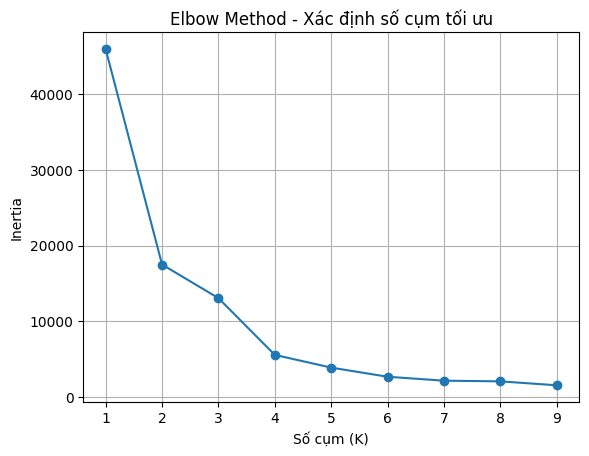

In [16]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(CO2_PCA)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title("Elbow Method - Xác định số cụm tối ưu")
plt.xlabel("Số cụm (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(CO2_PCA)

KMeans(n_clusters=3, n_init=10, random_state=42)

### Đánh giá mô hình bằng Silhouette_score

In [18]:
from sklearn.metrics import r2_score, silhouette_score

km_inertias, km_scores = [], []
for k in range(3, 10):
    km = KMeans(n_clusters=k).fit(X)
    km_inertias.append(km.inertia_)
    km_scores.append(silhouette_score(X, km.labels_))
    print(f"Processing K-Means with k = {k}, Intertia = {km.inertia_}, Silhoutte Score = {silhouette_score(X, km.labels_)}")
km_inertias

Processing K-Means with k = 3, Intertia = 34866.75598255408, Silhoutte Score = 0.9068651672076261
Processing K-Means with k = 4, Intertia = 32228.3463379461, Silhoutte Score = 0.791397677452159
Processing K-Means with k = 5, Intertia = 27164.465695399416, Silhoutte Score = 0.5823874433587743
Processing K-Means with k = 6, Intertia = 20620.62405579237, Silhoutte Score = 0.5151893965997094
Processing K-Means with k = 7, Intertia = 19480.53786742957, Silhoutte Score = 0.624295348472015
Processing K-Means with k = 8, Intertia = 18021.89570088178, Silhoutte Score = 0.5397036224276585
Processing K-Means with k = 9, Intertia = 14469.637528695434, Silhoutte Score = 0.5204824489267208


[34866.75598255408,
 32228.3463379461,
 27164.465695399416,
 20620.62405579237,
 19480.53786742957,
 18021.89570088178,
 14469.637528695434]

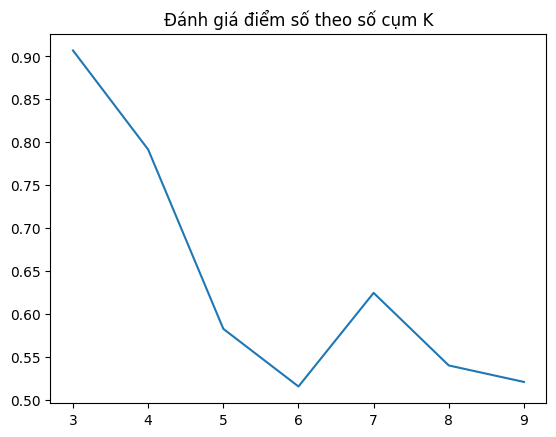

In [21]:
sns.lineplot (x=range(3,10), y=km_scores)
plt.title('Đánh giá điểm số theo số cụm K')
plt.show()

Xem các biến thành phần

In [22]:
# Hiển thị ma trận thành phần
pca_components = pd.DataFrame(
    pca.components_,
    columns=numeric_cols,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Xem biến nào ảnh hưởng mạnh nhất tới PC1 và PC2
print("=== Thành phần PCA ===")
display(pca_components.T)  # Hiển thị toàn bộ

# Hoặc chỉ lấy top biến có ảnh hưởng lớn nhất
print("\nTop biến ảnh hưởng đến PC1:")
print(pca_components.loc["PC1"].abs().sort_values(ascending=False).head(5))

print("\nTop biến ảnh hưởng đến PC2:")
print(pca_components.loc["PC2"].abs().sort_values(ascending=False).head(5))


=== Thành phần PCA ===


,PC1,PC2
population,0.280249,-0.274358
gdp,0.344343,0.047939
co2,0.356708,-0.091329
co2_per_capita,0.001989,0.043898
co2_per_gdp,0.003930,0.029923
co2_growth_abs,0.171056,-0.427037
co2_growth_prct,-0.002331,-0.017625
cement_co2,0.285972,-0.379906
coal_co2,0.318024,-0.299388
flaring_co2,0.201006,0.447373



Top biến ảnh hưởng đến PC1:
primary_energy_consumption     0.359765
co2                            0.356708
gdp                            0.344343
oil_co2                        0.330350
temperature_change_from_co2    0.320022
Name: PC1, dtype: float64

Top biến ảnh hưởng đến PC2:
flaring_co2       0.447373
co2_growth_abs    0.427037
gas_co2           0.392281
cement_co2        0.379906
coal_co2          0.299388
Name: PC2, dtype: float64


In [23]:
# Đảm bảo cột CO2 là số
df_country["co2"] = pd.to_numeric(df_country["co2"], errors="coerce")

# Gán nhãn cluster cho dữ liệu gốc
df_country["cluster"] = kmeans.labels_

# Tính trung bình CO2 theo cụm
cluster_summary = (
    df_country.groupby("cluster")["co2"]
    .mean()
    .sort_values()
)
print(cluster_summary)


cluster
0      94.538423
1    5562.299542
2    8776.318136
Name: co2, dtype: float64


### Vẽ biểu đồ

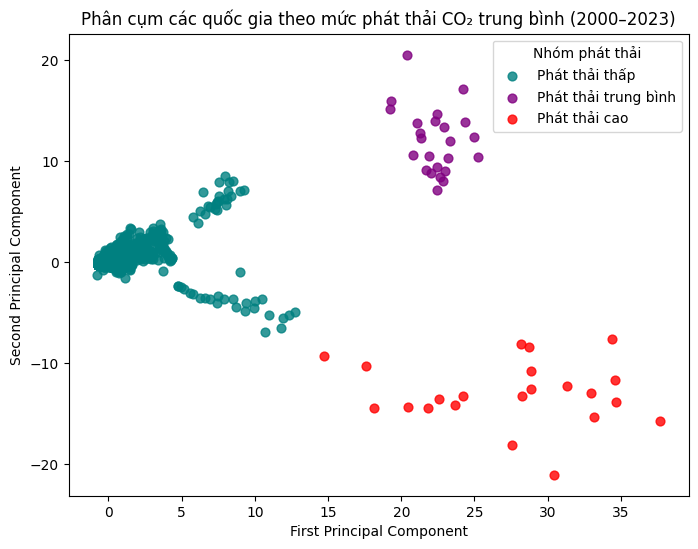

In [24]:
# Tạo mapping cụm → mức phát thải
cluster_labels = {
    0: "Phát thải thấp",
    1: "Phát thải trung bình",
    2: "Phát thải cao"
}

# Tạo mapping màu tương ứng
colors = {
    0: "teal",     # thấp
    1: "purple",       # trung bình
    2: "red"        # cao
}

# Vẽ scatter với màu theo mức phát thải
plt.figure(figsize=(8,6))
for cluster_id, label in cluster_labels.items():
    mask = kmeans.labels_ == cluster_id
    plt.scatter(
        CO2_PCA[mask, 0],
        CO2_PCA[mask, 1],
        c=colors[cluster_id],
        label=label,
        s=40,
        alpha=0.8
    )

plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title("Phân cụm các quốc gia theo mức phát thải CO₂ trung bình (2000–2023)")
plt.legend(title="Nhóm phát thải")
plt.show()
